In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.utils import to_categorical
from keras import Sequential
from keras import optimizers
from keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
%matplotlib inline

from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [2]:
# upravene vstupne data z datasetu: bola pouzita metoda random undersampling, ktora sluzi na vyrovnanie nevyvazenych vystupnych hodnot
# (v tomto pripade 97:3), teda iba 3% vsetkych filmov z datasetu ziskalo Oscara
# tato metoda vybera iba kazdy N-ty nahodny prvok z nadmerne reprezentovanych dat (v tomto pripade kazdy 30-ty prvok s premennou "oscars_won"=0)
# vysledkom je vyvazeny dataset v pomere zhruba 50:50

input = pd.read_csv("imdb_3.csv",sep=";")

# z datasetu su vybrane iba relevantne stlpce, ktore predstavuju 3 vstupne a 1 vystupnu premennu
training_data = input[["rating_imdb","votes_imdb","nominations","oscars_won"]]
# odstranenie prazdnych hodnot
training_data = training_data.dropna()
# pretypovanie na float
training_data["votes_imdb"] = training_data["votes_imdb"].astype(float)
training_data.tail(5)

,rating_imdb,votes_imdb,nominations,oscars_won
2249,8.1,76197.0,10,1
2250,5.2,183.0,0,0
2251,5.5,7029.0,0,0
2252,7.9,43253.0,1,1
2253,5.7,7453.0,3,0


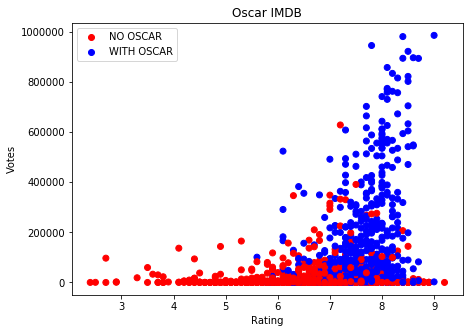

In [3]:
# zobrazenie grafu zavislosti hodnotenia a poctu hlasov na vysledok (filmy ktore ziskali Oscara)

# vstupne hodnoty plot_x a vystupne plot_y potrebne pre graf
plot_x= training_data.iloc[:,:3].values
plot_y= training_data.iloc[:,3].values

# upravenie vystupnych hodnot na binarne (1/-1)
plot_y = np.where(plot_y== 0,-1,1)

# implementacia grafu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.figure(figsize=(7,5))
plt.scatter(plot_x[:,0], plot_x[:,1], c=plot_y, cmap=cm_bright)
plt.scatter(None, None, color = 'r', label='NO OSCAR')
plt.scatter(None, None, color = 'b', label='WITH OSCAR')
plt.legend()

plt.title('Oscar IMDB')
plt.xlabel('Rating')
plt.ylabel('Votes')
plt.show()

In [4]:
#podobne ako pri grafe, vstupne a vystupne hodnoty pre neuronovu siet su upravene a standardizovane do potrebnej podoby

# rozdelenie vstupu x a vystupu y
X = training_data.iloc[:,:3]
y = training_data.iloc[:,3]

# kedze vystupom je pocet ziskanych Oscarov za film, no neuronova siet sa zabera len urcovanim ci dany film ziskal Oscara (ano/nie),
# vystup je upraveny do binarnej podoby (pre vsetky filmy, ktore ziskali aspon 1 Oscara je vystupom 1, inak 0)
y = np.where(y == 0,0,1)

# standardizovanie vstupnych hodnot: jednotlive stlpce dosahuju rozne priemerne hodnoty,
# napr. "rating_imdb" obsahuje hodnoty (0-10), "nominations" (0-200), pricom "votes_imdb" (pocet hlasov) dosahuje az 1000000 (milion),
# preto je potrebne data standardizovat a skalovat, v opacnom pripade neuronova siet moze uprednostnovat vysoke hodnoty
# a premenne "rating_imdb" spolu s "nominations" bude pri vyhodnocovani ignorovat
sc = StandardScaler()
X = sc.fit_transform(X)
X

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.53167894, -0.39204065, -0.38169192],
       [-0.309822  , -0.39247773, -0.38169192],
       [-2.08467748, -0.39294548, -0.38169192],
       ...,
       [-1.75189208, -0.3403963 , -0.38169192],
       [ 0.91039114, -0.06262865, -0.30165301],
       [-1.53003515, -0.33714504, -0.14157521]])

In [5]:
# rozdelenie dat na trenovacie a testovacie a implementacia neuronovej siete Keras

# vstupne aj vystupne data su rozdelene v pomere 7:3 (train:test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifier = Sequential()
# pridanie prvej skrytej vrstvy s 10 neuronmi
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal', input_dim=3))
# druha skryta vrstva, 5 neuronov
classifier.add(Dense(5, activation='relu', kernel_initializer='random_normal'))
#vystupna vrstva
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#v pripade skrytych vrstiev bola pouzita aktivacna funkcia "relu", pri vystupnej vrstve to je "sigmoid", popisane v prezentacii

# kompilacia NN, s optimalizatorom "Adam" a funkciou strat (resp. chybovosti) "mean_squared_error", popisane v prezentacii
classifier.compile(optimizer ="adam",loss='mean_squared_error', metrics =['accuracy'])

# samotne trenovanie neuoronovej siete, na kazdu aktualizaciu gradientu je pouzitych 20 vzoriek (batch size),
# pocet iteracii nad celym suborom udajov je 50 (epochs),
# data nad ktorymi bude NN validovana su testovacie data, ktore boli oddelene od trenovacich v predoslych krokoch
history = classifier.fit(X_train,y_train, batch_size=10, epochs=50, validation_data=[X_test, y_test])

Train on 1477 samples, validate on 634 samples
Epoch 1/50
1477/1477 [==============================] - 1s 502us/step - loss: 0.2435 - acc: 0.6913 - val_loss: 0.2224 - val_acc: 0.7287
Epoch 2/50
1477/1477 [==============================] - 0s 243us/step - loss: 0.1962 - acc: 0.7461 - val_loss: 0.1778 - val_acc: 0.7303
Epoch 3/50
1477/1477 [==============================] - 0s 264us/step - loss: 0.1721 - acc: 0.7508 - val_loss: 0.1711 - val_acc: 0.7334
Epoch 4/50
1477/1477 [==============================] - 0s 288us/step - loss: 0.1675 - acc: 0.7508 - val_loss: 0.1675 - val_acc: 0.7350
Epoch 5/50
1477/1477 [==============================] - 0s 229us/step - loss: 0.1648 - acc: 0.7569 - val_loss: 0.1657 - val_acc: 0.7429
Epoch 6/50
1477/1477 [==============================] - 0s 245us/step - loss: 0.1622 - acc: 0.7596 - val_loss: 0.1623 - val_acc: 0.7492
Epoch 7/50
1477/1477 [==============================] - 0s 279us/step - loss: 0.1599 - acc: 0.7657 - val_loss: 0.1605 - val_acc: 0.7476
E

In [6]:
# evalvacia modelu trenovacich dat, ktora zobrazuje presnost (accuracy) NN

eval_model=classifier.evaluate(X_train, y_train)
# "eval_model" predstavuje hodnoty strat a presnosti pre trenovaci rezim NN
print(eval_model)
print("\nAccuracy: %.2f%%\nLoss: %.2f%%" % (eval_model[1]*100, eval_model[0]*100))

1477/1477 [==============================] - 0s 58us/step
[0.13939449878140892, 0.8341232227891704]

Accuracy: 83.41%
Loss: 13.94%


In [7]:
# predikcia NN na novych, testovacich datach a vytvorenie "confussion matrix" = matice,
# ktora predstavuje pocet spravnych a nespravnych predikcii vzhladom na vystupne data (0 a 1)

y_pred = classifier.predict_classes(X_test)
y_pred = (y_pred>0.5)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[267  58]
 [ 48 261]]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


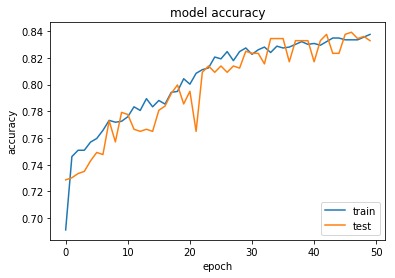

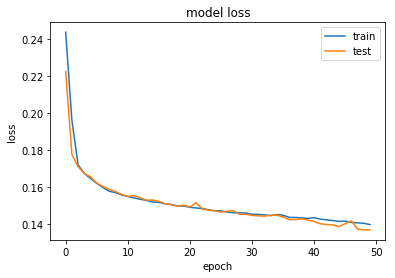

In [8]:
# grafy zobrazujuce historiu ucenia sa neuronovej siete, takisto ako predikcie na testovacich datach
# zobrazuje sa presnost (prvy graf) a tiez chybovost (druhy graf) vzhladom na jednotlive epochy

print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [9]:
# testovanie na realnych datach: prvych 10 najlepsie hodnotenych filmov z databazy IMDB
# kedze pri tychto filmoch je velka pravdepodobnost, ze ziskala aspon 1 ocenenie Oscara, zobrazime na tom predikciu
# neuronovej siete a pravdepodobnosti, s ktorymi pracuje pri rozhodovani medzi vystupmi 0 a 1
# pre porovnanie bol pridany tiez prvok "Priemerné hodnoty", ktory predstavuje priemerny film podla hodnot jednotlivych premennych (mean)

Xnew = np.array([["The Shawshank Redemption",0,9.3,2085306,39],
                 ["The Godfather",1,9.2,1430981,28],
                 ["The Godfather: Part II",1,9.0,993787,20],
                 ["The Dark Knight",1,9.0,2051814,154],
                 ["12 Angry Men",0,8.9,590255,11],
                 ["Schindler's List",1,8.9,1080804,49],
                 ["The Lord of the Rings: The Return of the King",1,8.9,1484224,122],
                 ["Pulp Fiction",1,8.9,1630176,69],
                 ["Il buono, il brutto, il cattivo",0,8.9,619081,3],
                 ["Fight Club",0,8.8,1667509,37],
                 ["TEST",0,10000,100000000,10000]])
#podobne ako pri trenovacich a testovacich datach je potrebne hodnoty standardizovat a skalovat
test_data = sc.fit_transform(Xnew[:,2:])

# predikcia
ynew = classifier.predict_classes(test_data)
ynew_percent = classifier.predict_proba(test_data)

# zobrazenie výstupu
output = [["MOVIE","OSCAR","PREDICTION","%"]]
for i in range(len(Xnew)):
    output.append([Xnew[i][0], Xnew[i][1], str(ynew[i]), str(ynew_percent[i])])
    
# formátovanie výstupu do tabuľky (zarovnanie stlpcov)
widths = [max(map(len, col)) for col in zip(*output)]
for row in output:
    print ("  ".join((val.ljust(width+1) for val, width in zip(row, widths))))

MOVIE                                           OSCAR   PREDICTION   %            
The Shawshank Redemption                        0       [0]          [0.36295158] 
The Godfather                                   1       [0]          [0.35144424] 
The Godfather: Part II                          1       [0]          [0.34305292] 
The Dark Knight                                 1       [1]          [0.5068673]  
12 Angry Men                                    0       [0]          [0.3335753]  
Schindler's List                                1       [0]          [0.37709296] 
The Lord of the Rings: The Return of the King   1       [0]          [0.46722797] 
Pulp Fiction                                    1       [0]          [0.40018177] 
Il buono, il brutto, il cattivo                 0       [0]          [0.32444948] 
Fight Club                                      0       [0]          [0.36136535] 
TEST                                            0       [1]          [0.9999999]  


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U45 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U45 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
